# Anime Recommendations Database

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

In [12]:
df = pd.read_csv(r"Data/anime.csv")
df.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


Let's check if there are empty cells and the importance of them in relation of the amount of data

In [13]:
df.isna().sum() / df.shape[0]

anime_id    0.000000
name        0.000000
genre       0.005043
type        0.002034
episodes    0.000000
rating      0.018708
members     0.000000
dtype: float64

So, the percentage of empty cells is smaller the 0,1% and I believe that they have very small impact on the overview the dataset, and it is easier to delete rows without some data.

In [14]:
df.dropna(inplace = True)
df.isna().sum()

anime_id    0
name        0
genre       0
type        0
episodes    0
rating      0
members     0
dtype: int64

There is no empty cells


I'll make a function which will count number of genres in each anime


In [15]:
example = "Drama, Romance, School, Supernatural"  # Значения первой строчки


def f(s: str):
	s = s.split(", ")
	s = len(s)
	return s


f(example)
df["genre_count"] = df.genre.apply(f)
df.genre_count

0        4
1        7
2        7
3        2
4        7
        ..
12289    1
12290    1
12291    1
12292    1
12293    1
Name: genre_count, Length: 12017, dtype: int64

#### Добавить описание, что это и зачем

In [16]:
df.genre[df.genre.isna()]

Series([], Name: genre, dtype: object)

#### Добавить описание, что это и зачем

In [17]:
df["genre_count"] = df.genre.apply(f)
df.genre_count


0        4
1        7
2        7
3        2
4        7
        ..
12289    1
12290    1
12291    1
12292    1
12293    1
Name: genre_count, Length: 12017, dtype: int64

I suppose that the more different genres the more rating is.Let's check if there is a correlation between number of genres and rating.

In [18]:
px.scatter(df, x = "genre_count", y = df.rating, trendline = "ols")

So the correlation can be seen, but it is not very representative, because for example anime with 1 or 2 genres also have different ratings from 1 to 10, and the highest rating has anime with two genres. So probably the correlation is just a coincidence.

Lets check how many animes with different genres 



<Axes: ylabel='count'>

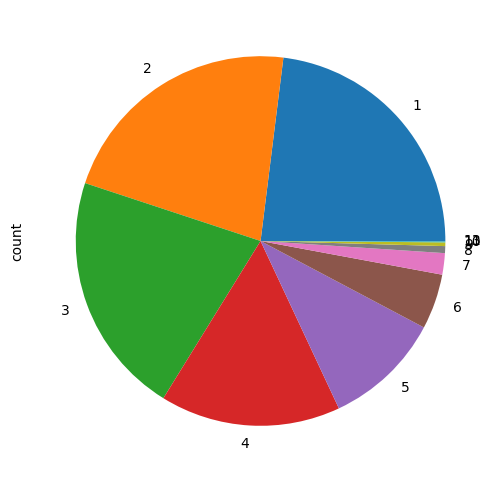

In [19]:
df.genre_count.value_counts().plot.pie(
	figsize = (6, 6)
)

So there is no sence to chaeck animes with more than 7 genres, because the percentage of them is too small. Cosequently the information in previous graph is not relevant а for making such conclusions.

Lets check what genres are the most widespread in this dataset

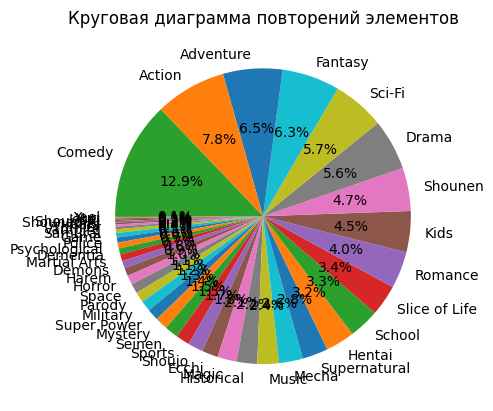

In [60]:
list_df = df.genre.tolist()

result_list = []

for i in list_df:
	for j in i.split(", "):
		result_list.append(j)

counts = {}
for item in result_list:
	counts[item] = counts.get(item, 0) + 1

counts = dict(sorted(counts.items(), key = lambda item: item[1], reverse = False))

labels = list(counts.keys())
values = list(counts.values())

plt.pie(values, labels = labels, autopct = '%1.1f%%', startangle = 180)

plt.title('Круговая диаграмма повторений элементов')

plt.show()